# Subgroup Robustness Grows on Trees (Experiments)
Here are some initial experiments corroborating the empirical observations from *Subgroup Robustness Grows on Trees*.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random

from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer

## Datasets Overview
We'll run experiments on four datasets typically used in the fairness and robustness literature:

1. ACS Income (*large*). $n = 499,350$ examples, $20$ features, sensitive groups: *Race* and *Sex*.
2. ACS Employment (*large*). $n = 376,035$ examples, $17$ features, sensitive groups: *Race* and *Sex*. 
3. Adult (*medium*) $n = 48,845$ examples, $14$ features, sensitive groups: *Race* and *Sex*.
4. Communities and Crime (*small*) $n = 1,994$ examples, $113$ features, sensitive groups: *Income Level* and *Race.*

We also plan to do experiments with a fifth synthetic dataset that has overlapping group structure.

# Adult Dataset (Overlapping Groups)
The Adult Dataset is a benchmark derived from 1994 US Census data. The task is to predict whether an individual's income
exceeds $50,000 (binary classification). Sensitive attributes are *Race* and *Sex*.

- *Race:* $\{\text{White}, \text{Asian-Pac-Islander}, \text{Amer-Indian-Eskimo}, \text{Other}, \text{Black} \}$
- *Sex:* $\{\text{Male}, \text{Female}\}$

The standard in the literature has been to simplify the groups for *Race* to $\text{White}$ and $\text{NotWhite}$.

## Preprocess and Clean Adult
The Adult dataset is a binary classification task with *categorical* and *numerical* features. We binarize the categorical
features with `OneHotEncoder` and normalize the numerical features with `MinMaxScaler`. We also drop all the rows with missing
features, leaving us with $n = 45,222$ examples total.

In [2]:
# Adult Dataset
adult_names = ["age", "workclass", "fnlwgt", "education", "education-num",
                "marital-status", "occupation", "relationship", "race", "sex",
                "capital-gain", "capital-loss", "hours-per-week", "native-country", 
                "income"]
adult_data = pd.read_csv("./datasets/adult/adult.data", header=None, names=adult_names, na_values=' ?')
adult_data = adult_data.apply(lambda x: x.str.strip() if x.dtype == "object" else x) # strip whitespace
adult_test = pd.read_csv("./datasets/adult/adult.test", header=None, names=adult_names, na_values=' ?')
adult_test = adult_test.apply(lambda x: x.str.strip() if x.dtype == "object" else x) # strip whitespace
dfs = [adult_data, adult_test]
adult_df = pd.concat(dfs)
adult_df = adult_df.dropna()
adult_df = adult_df.apply(lambda x: x.str.strip() if x.dtype == "object" else x) # strip whitespace
print("Adult Shape: {}".format(adult_df.shape))

# last column in adult has some textual discrepancy
adult_df = adult_df.replace(">50K.", ">50K")
adult_df = adult_df.replace("<=50K.", "<=50K")

# Split into X and y
X, y = adult_df.drop("income", axis=1), adult_df["income"]

# Select categorical and numerical features
cat_idx = X.select_dtypes(include=["object", "bool"]).columns
num_idx = X.select_dtypes(include=['int64', 'float64']).columns
steps = [('cat', OneHotEncoder(handle_unknown='ignore'), cat_idx), ('num', MinMaxScaler(), num_idx)]
col_transf = ColumnTransformer(steps)

# label encoder to target variable so we have classes 0 and 1
assert(len(np.unique(y)) == 2)
y = LabelEncoder().fit_transform(y)
print("% examples >=50k (y=1): {}".format(100 * len(np.where(y == 1)[0])/len(y)))
print("% examples <50k (y=0): {}".format(100 * len(np.where(y == 0)[0])/len(y)))

Adult Shape: (45222, 15)
% examples >=50k (y=1): 24.78439697492371
% examples <50k (y=0): 75.21560302507629


Traditionally, there are $|\mathcal{G}| = 4$ groups in Adult: *(White, Male), (NotWhite, Male), (White, Female),* and *(NotWhite, Female)*.

In this notebook, we will instead do the following group structure for Adult:
- Overlapping groups (make *White* and *NotWhite* their own groups, make *Male* and *Female* their own groups).


In [19]:
def adult_gp_indices(df, race_val, sex_val):
    if race_val == "NotWhite":
        return np.where((df['race'] != 'White') & (df['sex'] == sex_val))
    else:
        return np.where((df['race'] == race_val) & (df['sex'] == sex_val))

group_names = ["ALL", "W,M", "W,F", "nW,M", "nW,F", "W", "nW", "M", "F"]
group_memberships = []
group_memberships.append([True] * y.shape[0])
race_gps_coarse = ["White", "NotWhite"]
sex_gps = ["Male", "Female"]

# Traditional disjoint groups
for race in race_gps_coarse:
    for sex in sex_gps:
        indices = adult_gp_indices(X, race, sex)[0]
        membership = np.zeros(y.shape[0], dtype=bool)
        membership[indices] = True
        group_memberships.append(membership)

# Add 4 overlapping groups
w_indices = np.where(X['race'] == 'White')
w_membership = np.zeros(y.shape[0], dtype=bool)
w_membership[w_indices] = True
group_memberships.append(w_membership)

nw_indices = np.where(X['race'] != 'White')
nw_membership = np.zeros(y.shape[0], dtype=bool)
nw_membership[nw_indices] = True
group_memberships.append(nw_membership)

m_indices = np.where(X['sex'] == 'Male')
m_membership = np.zeros(y.shape[0], dtype=bool)
m_membership[m_indices] = True
group_memberships.append(m_membership)

f_indices = np.where(X['sex'] == 'Female')
f_membership = np.zeros(y.shape[0], dtype=bool)
f_membership[f_indices] = True
group_memberships.append(f_membership)

num_groups = len(group_memberships)
print('num_groups = {0}'.format(num_groups))

num_groups = 9


In [20]:
# Fit the ColumnTransformer to X
X_transf = col_transf.fit_transform(X)
print("Column-transformed X has shape: {}".format(X_transf.shape))

# Train-test split
splits = train_test_split(*tuple([X, y] + group_memberships), test_size=0.2, random_state=0)
X_train = splits[0]
X_test = splits[1]
y_train = splits[2]
y_test = splits[3]

# group_train
group_train = splits[4::2]
group_test = splits[5::2]

Column-transformed X has shape: (45222, 104)


In [21]:
# group_train and group_test have the indices in X_train, X_test (respectively)
# for each group, as a binary mask.
num_group_train = {}
num_group_test = {}

# TODO: fix column alignment issue :(
print('Group\t\t\ttrain\ttest')
for g in range(num_groups):
    num_group_train[g] = np.sum(group_train[g])
    num_group_test[g] = np.sum(group_test[g])
    print('{0} ({3})\t\t\t{1}\t{2}'.format(g, num_group_train[g], num_group_test[g], group_names[g]))

Group			train	test
0 (ALL)			36177	9045
1 (W,M)			21603	5417
2 (W,F)			9520	2363
3 (nW,M)			2815	692
4 (nW,F)			2239	573
5 (W)			31123	7780
6 (nW)			5054	1265
7 (M)			24418	6109
8 (F)			11759	2936


In [22]:
for i in range(num_groups):
    print('P(Y=1 | group {0}) = {1}'.format(i, np.mean(y_test[group_test[i]])))

P(Y=1 | group 0) = 0.24378109452736318
P(Y=1 | group 1) = 0.31733431788812994
P(Y=1 | group 2) = 0.12018620397799408
P(Y=1 | group 3) = 0.22687861271676302
P(Y=1 | group 4) = 0.07853403141361257
P(Y=1 | group 5) = 0.25745501285347044
P(Y=1 | group 6) = 0.15968379446640316
P(Y=1 | group 7) = 0.307087903093796
P(Y=1 | group 8) = 0.11205722070844687


## Fit and Evaluate Models (Adult)
We fit and evaluate our models here. There are four classes of models we'd like to evaluate:
1. *Tree-based models.* Includes Random Forests and Gradient-Boosted Trees.
2. *Baseline models.* Includes SVM, Logistic Regression, and a 2-layer neural net.
3. *Prepend.* Use all of the above as base classes.
4. *DRO.* Includes Group DRO and $\chi^2$-DRO, each with the base hypothesis class of 2-layer neural nets.

In [23]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

from joblib import Parallel, delayed

In [37]:
# Utilities for fitting and evaluating models
def std_err(test_err, n_g):
    return np.sqrt(2. * test_err * (1.0 - test_err) / n_g)

def prepend(models, X_train, group_train, X_test, group_test, y_train, y_test,
            transformer, num_groups, epsilon=0, verbose=False):
    f = [0]
    #epsilon = 0.01
    epsilon = 0

    H_train = {}
    H_test = {}
    H_train_err = {}
    for g in range(num_groups):
        H_train[g] = models[g].predict(transformer.transform(X_train))
        H_test[g] = models[g].predict(transformer.transform(X_test))
        H_train_err[g] = np.mean(H_train[g][group_train[g]] != y_train[group_train[g]])
    F_train = H_train[0].copy()
    F_test = H_test[0].copy()
    F_train_err = {}
    for g in range(num_groups):
        F_train_err[g] = np.mean(F_train[group_train[g]] != y_train[group_train[g]])
    while True:
        #scores = [H_train_err[g] + np.sqrt(2.0 * H_train_err[g] * (1.0 - H_train_err[g])/num_group_train[g]) - F_train_err[g] for g in range(num_groups)]
        scores = [H_train_err[g] + epsilon - F_train_err[g] for g in range(num_groups)]
        g = np.argmin(scores)
        if scores[g] < 0.:
            f.insert(0,g) # prepend g to the list f
            F_train[group_train[g]] = H_train[g][group_train[g]]
            F_test[group_test[g]] = H_test[g][group_test[g]]
            for g in range(num_groups):
                F_train_err[g] = np.mean(F_train[group_train[g]] != y_train[group_train[g]])
        else:
            break

    F_test_err = {}
    for g in range(num_groups):
        F_test_err[g] = np.mean(F_test[group_test[g]] != y_test[group_test[g]])
        if verbose:
            print('PREPEND group {0} ({4}): {1} (+/-{2}; n={3})'.format(g, F_test_err[g], std_err(F_test_err[g], num_group_test[g]), num_group_test[g], group_names[g]))

    return f, F_test_err

def train_and_eval(X_train, group_train, 
                   X_test, group_test, 
                   y_train, y_test, 
                   transformer, num_groups, 
                   model, model_name, 
                   param_name, param_val,
                   params={}, verbose=False):
    if verbose:
        print("{0} ({1}={2})".format(model_name, param_name, param_val))
    models = {}
    yhats = {}
    test_err = {}
    erm_test_err = {}

    # train and evaluate all models
    for g in range(num_groups):
        models[g] = model(**params)
        models[g].fit(transformer.transform(X_train[group_train[g]]), y_train[group_train[g]])
        yhats[g] = models[g].predict(transformer.transform(X_test))
        test_err[g] = np.mean(y_test[group_test[g]] != yhats[g][group_test[g]])
        if verbose:
            print('group {0} ({4}): {1} (+/-{2}; n={3})'.format(g,test_err[g], std_err(test_err[g], num_group_test[g]), num_group_test[g], group_names[g]))
    for g in range(num_groups):
        erm_test_err[g] = np.mean(y_test[group_test[g]] != yhats[0][group_test[g]])
    
    dec_list, F_test_err = prepend(models, X_train, group_train, X_test, group_test, y_train, y_test, col_transf, num_groups, verbose=verbose)
    return models, yhats, test_err, erm_test_err, dec_list, F_test_err

### Tree-Based Models
We train the following models:

1. *Random Forest.*
2. *Random Forest, per group.*
3. *Prepend (Random Forest).*
4. *Gradient-Boosted Trees.*
5. *Gradient-Boosted Trees, per group.*
6. *Prepend (Gradient Boosted Trees).*

using a hyperparameter sweep of: $\mathrm{num\_estimators} = \{ 64, 128, 256, 512, 1024 \}.$

In [24]:
all_rfs = {}            # indexed by num_estimator
rf_prepend = {}         # indexed by num_estimator
all_gbs = {}            # indexed by num_estimator
gb_prepend = {}         # indexed by num_estimator

In [39]:
# Train and evaluate: Random Forests
# For parallelizing the hyperparameter sweep
num_estimator_params = [1, 64, 128, 256, 512, 1024]
param_dicts = [{'n_estimators' : n_estimators, 'random_state' : 0} for n_estimators in num_estimator_params]
iterate_params = zip(num_estimator_params, param_dicts)

parallel = Parallel(n_jobs=-1, verbose=10)
results = parallel(
    delayed(train_and_eval)(X_train, group_train, 
                   X_test, group_test, 
                   y_train, y_test, 
                   col_transf, num_groups, 
                   RandomForestClassifier, "Random Forests", 
                   "n_estimators", param_val=n_estimators,
                   params=params, verbose=False
    )
    for n_estimators, params in iterate_params
)

# Populate dictionaries with results
for i, result in enumerate(results):
    all_rfs[num_estimator_params[i]] = {}
    all_rfs[num_estimator_params[i]]['models'] = result[0]
    all_rfs[num_estimator_params[i]]['yhats'] = result[1]
    all_rfs[num_estimator_params[i]]['test_err'] = result[2]
    all_rfs[num_estimator_params[i]]['erm_test_err'] = result[3]

    rf_prepend[num_estimator_params[i]] = {}
    rf_prepend[num_estimator_params[i]]['model'] = result[4]
    rf_prepend[num_estimator_params[i]]['F_test_err'] = result[5]

del results
del parallel

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   6 | elapsed:   44.7s remaining:  1.5min
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:  1.4min remaining:  1.4min
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:  2.5min remaining:  1.3min
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:  8.5min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:  8.5min finished


In [40]:
# Train and evaluate: Gradient-Boosted Trees
# IMPORTANT: need to re-initialize the iterate_params because zip is an iterable
num_estimator_params = [1, 64, 128, 256, 512, 1024]
param_dicts = [{'n_estimators' : n_estimators, 'random_state' : 0} for n_estimators in num_estimator_params]
iterate_params = zip(num_estimator_params, param_dicts)

with Parallel(n_jobs=-1, verbose=10) as parallel:
    results = parallel(
        delayed(train_and_eval)(X_train, group_train, 
                    X_test, group_test, 
                    y_train, y_test, 
                    col_transf, num_groups, 
                    GradientBoostingClassifier, "Gradient-Boosted Trees", 
                    "n_estimators", param_val=n_estimators,
                    params=params, verbose=False
        )
        for n_estimators, params in iterate_params
    )

    # Populate dictionaries with results
    for i, result in enumerate(results):
        all_gbs[num_estimator_params[i]] = {}
        all_gbs[num_estimator_params[i]]['models'] = result[0]
        all_gbs[num_estimator_params[i]]['yhats'] = result[1]
        all_gbs[num_estimator_params[i]]['test_err'] = result[2]
        all_gbs[num_estimator_params[i]]['erm_test_err'] = result[3]

        gb_prepend[num_estimator_params[i]] = {}
        gb_prepend[num_estimator_params[i]]['model'] = result[4]
        gb_prepend[num_estimator_params[i]]['F_test_err'] = result[5]

    del results
    del parallel

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   6 | elapsed:   14.7s remaining:   29.3s
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:   26.6s remaining:   26.6s
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:   47.6s remaining:   23.8s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:  2.6min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:  2.6min finished


### Baseline Models
We train and evaluate with three different baseline models. This gives nine different varieties of models.

1. *Logistic Regression.*
2. *Logistic Regression, per group.*
3. *Prepend (Logistic Regression).*
4. *SVM.*
5. *SVM, per group.*
6. *Prepend (SVM).*
7. *2-layer MLP (varying hidden units).*
8. *2-layer MLP, per group.*
9. *Prepend (2-layer MLP).*

The hyperparameter sweep for the MLP is: $\mathrm{hidden\_units} := \{64, 128, 256\}.$

In [41]:
logreg = {}      
logreg_prepend = {}
svm = {}
svm_prepend = {}
all_mlps = {}
mlps_prepend = {}

In [42]:
# Train and evaluate: Logistic Regression
logreg_params = {
    "cv": 3,
    "max_iter": 500
}
result = train_and_eval(X_train, group_train,
                        X_test, group_test,
                        y_train, y_test,
                        col_transf, num_groups,
                        LogisticRegressionCV, "Logistic Regression",
                        param_name="CV", param_val=3, params=logreg_params,
                        verbose=True)

logreg['models'] = result[0]
logreg['yhats'] = result[1]
logreg['test_err'] = result[2]
logreg['erm_test_err'] = result[3]
logreg_prepend['model'] = result[4]
logreg_prepend['F_test_err'] = result[5]

Logistic Regression (CV=3)
group 0 (ALL): 0.14892205638474296 (+/-0.005293889747457745; n=9045)
group 1 (W,M): 0.19198818534244047 (+/-0.0075680098284835315; n=5417)
group 2 (W,F): 0.07829030892932713 (+/-0.00781509420174876; n=2363)
group 3 (nW,M): 0.13872832369942195 (+/-0.0185829476110788; n=692)
group 4 (nW,F): 0.06108202443280977 (+/-0.014148429167305701; n=573)
group 5 (W): 0.15694087403598972 (+/-0.005832063577890563; n=7780)
group 6 (nW): 0.10039525691699605 (+/-0.011949567892401999; n=1265)
group 7 (M): 0.0739100817438692 (+/-0.006828343995212222; n=2936)
group 8 (F): 0.1871009985267638 (+/-0.007056450233129572; n=6109)
PREPEND group 0 (ALL): 0.14991708126036485 (+/-0.005308440039837308; n=9045)
PREPEND group 1 (W,M): 0.19198818534244047 (+/-0.0075680098284835315; n=5417)
PREPEND group 2 (W,F): 0.07829030892932713 (+/-0.00781509420174876; n=2363)
PREPEND group 3 (nW,M): 0.13872832369942195 (+/-0.0185829476110788; n=692)
PREPEND group 4 (nW,F): 0.06108202443280977 (+/-0.0141484

In [43]:
# Train and evaluate: SVM
# Train and evaluate: Logistic Regression
svm_params = {}
result = train_and_eval(X_train, group_train,
                        X_test, group_test,
                        y_train, y_test,
                        col_transf, num_groups,
                        SVC, "SVM",
                        param_name="noparams", param_val="noparams", params=svm_params,
                        verbose=True)

svm['models'] = result[0]
svm['yhats'] = result[1]
svm['test_err'] = result[2]
svm['erm_test_err'] = result[3]
svm_prepend['model'] = result[4]
svm_prepend['F_test_err'] = result[5]

SVM (noparams=noparams)
group 0 (ALL): 0.16263128800442234 (+/-0.005487456970751335; n=9045)
group 1 (W,M): 0.2106331918035813 (+/-0.007834989430363214; n=5417)
group 2 (W,F): 0.090562843842573 (+/-0.008349193182249071; n=2363)
group 3 (nW,M): 0.17341040462427745 (+/-0.020353752703390026; n=692)
group 4 (nW,F): 0.06631762652705062 (+/-0.014701165075800321; n=573)
group 5 (W): 0.17133676092544986 (+/-0.00604142672165842; n=7780)
group 6 (nW): 0.12015810276679842 (+/-0.01292851327508322; n=1265)
group 7 (M): 0.08685286103542235 (+/-0.007350204429370065; n=2936)
group 8 (F): 0.20461614012113274 (+/-0.007299418537893582; n=6109)
PREPEND group 0 (ALL): 0.16263128800442234 (+/-0.005487456970751335; n=9045)
PREPEND group 1 (W,M): 0.2074949233893299 (+/-0.0077918457103755565; n=5417)
PREPEND group 2 (W,F): 0.08463817181548879 (+/-0.008097718454620994; n=2363)
PREPEND group 3 (nW,M): 0.16329479768786126 (+/-0.01987166969487615; n=692)
PREPEND group 4 (nW,F): 0.059336823734729496 (+/-0.013957797

In [44]:
# Train and evaluate: MLP
# For parallelizing the hyperparameter sweep over MLP hidden units
import warnings
warnings.filterwarnings('ignore') 

hidden_layer_params = [[64, 64], [128, 128], [256, 256]]
hidden_layer_param_names = [64, 128, 256]
param_dicts = [{'hidden_layer_sizes' : hidden_layer, 'batch_size' : 128} for hidden_layer in hidden_layer_params]
iterate_params = zip(hidden_layer_param_names, param_dicts)

parallel_mvp = Parallel(n_jobs=-1, verbose=10)
results = parallel_mvp(
    delayed(train_and_eval)(X_train, group_train, 
                   X_test, group_test, 
                   y_train, y_test, 
                   col_transf, num_groups, 
                   MLPClassifier, "2-Layer MLP", 
                   "hidden_units", param_val=hidden_units,
                   params=params, verbose=False
    )
    for hidden_units, params in iterate_params
)

# Populate dictionaries with results
for i, result in enumerate(results):
    all_mlps[hidden_layer_param_names[i]] = {}
    all_mlps[hidden_layer_param_names[i]]['models'] = result[0]
    all_mlps[hidden_layer_param_names[i]]['yhats'] = result[1]
    all_mlps[hidden_layer_param_names[i]]['test_err'] = result[2]
    all_mlps[hidden_layer_param_names[i]]['erm_test_err'] = result[3]

    mlps_prepend[hidden_layer_param_names[i]] = {}
    mlps_prepend[hidden_layer_param_names[i]]['model'] = result[4]
    mlps_prepend[hidden_layer_param_names[i]]['F_test_err'] = result[5]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/Users/essdee/miniconda3/envs/tree_robust/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/essdee/miniconda3/envs/tree_robust/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/essdee/miniconda3/envs/tree_robust/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/essdee/miniconda3/envs/tree_robust/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Sto

## Plot Results (Adult)

### Find Worst-Group Errors
For each model, we find the worst-group errors for simplifying each of the following plots.

In [50]:
# find the worst-group errors for each tree-based model
tree_params = [1, 64, 128, 256, 512, 1024]
for n_trees in tree_params:
    max_err_rf = -np.inf
    max_err_rf_prepend = -np.inf
    max_err_gb = -np.inf
    max_err_gb_prepend = -np.inf

    argmax_err_rf = None
    argmax_err_rf_prepend = None
    argmax_err_gb = None
    argmax_err_gb_prepend = None

    for g in range(1, num_groups):  # skip the ALL group
        if all_rfs[n_trees]['erm_test_err'][g] > max_err_rf:
            max_err_rf = all_rfs[n_trees]['erm_test_err'][g]
            argmax_err_rf = g
        if rf_prepend[n_trees]['F_test_err'][g] > max_err_rf_prepend:
            max_err_rf_prepend = rf_prepend[n_trees]['F_test_err'][g]
            argmax_err_rf_prepend = g
        if all_gbs[n_trees]['erm_test_err'][g] > max_err_gb:
            max_err_gb = all_gbs[n_trees]['erm_test_err'][g]
            argmax_err_gb = g
        if gb_prepend[n_trees]['F_test_err'][g] > max_err_gb_prepend:
            max_err_gb_prepend = gb_prepend[n_trees]['F_test_err'][g]
            argmax_err_gb_prepend = g
        
    all_rfs[n_trees]['worst_gp_err'] = (max_err_rf, argmax_err_rf)
    rf_prepend[n_trees]['worst_gp_err'] = (max_err_rf_prepend, argmax_err_rf_prepend)
    all_gbs[n_trees]['worst_gp_err'] = (max_err_gb, argmax_err_gb)
    gb_prepend[n_trees]['worst_gp_err'] = (max_err_gb_prepend, argmax_err_gb_prepend)

In [51]:
# find the worst-group errors for each baseline model
max_err_logreg = -np.inf
max_err_logreg_prepend = -np.inf
max_err_svm = -np.inf
max_err_svm_prepend = -np.inf

argmax_err_logreg = None
argmax_err_logreg_prepend = None
argmax_err_svm = None
argmax_err_svm_prepend = None

for g in range(1, num_groups):  # skip the ALL group
    if logreg['erm_test_err'][g] > max_err_logreg:
        max_err_logreg = logreg['erm_test_err'][g]
        argmax_err_logreg = g
    if logreg_prepend['F_test_err'][g] > max_err_logreg_prepend:
        max_err_logreg_prepend = logreg_prepend['F_test_err'][g]
        argmax_err_logreg_prepend = g
    if svm['erm_test_err'][g] > max_err_svm:
        max_err_svm = svm['erm_test_err'][g]
        argmax_err_svm = g
    if svm_prepend['F_test_err'][g] > max_err_svm_prepend:
        max_err_svm_prepend = svm_prepend['F_test_err'][g]
        argmax_err_svm_prepend = g

logreg['worst_gp_err'] = (max_err_logreg, argmax_err_logreg)
logreg_prepend['worst_gp_err'] = (max_err_logreg_prepend, argmax_err_logreg_prepend)
svm['worst_gp_err'] = (max_err_svm, argmax_err_svm)
svm_prepend['worst_gp_err'] = (max_err_svm_prepend, argmax_err_svm_prepend)

In [52]:
# find the worst-group errors for each MLP model
hidden_unit_params = [64, 128, 256]
for hidden_units in hidden_unit_params:
    max_err_mlp = -np.inf
    max_err_mlp_prepend = -np.inf

    argmax_err_mlp = None
    argmax_err_mlp_prepend = None

    for g in range(1, num_groups):  # skip the ALL group
        if all_mlps[hidden_units]['erm_test_err'][g] > max_err_mlp:
            max_err_mlp = all_mlps[hidden_units]['erm_test_err'][g]
            argmax_err_mlp = g
        if mlps_prepend[hidden_units]['F_test_err'][g] > max_err_mlp_prepend:
            max_err_mlp_prepend = mlps_prepend[hidden_units]['F_test_err'][g]
            argmax_err_mlp_prepend = g
        
    all_mlps[hidden_units]['worst_gp_err'] = (max_err_mlp, argmax_err_mlp)
    mlps_prepend[hidden_units]['worst_gp_err'] = (max_err_mlp_prepend, argmax_err_mlp_prepend)

### Plot 1: Overall Comparison
For each group, we compare the following models:

1. **RF-Best.** The Random Forest model (instance of `n_estimators`) with the lowest worst-group risk.
2. **GBM-Best.** The Gradient-Boosted Trees model (instance of `n_estimators`) with the lowest worst-group risk.
3. **Baseline-Best.** The baseline model (out of Logistic Regression and SVM) with the lowest worst-group risk.
4. **Baseline-Best-Group.** Using the baseline model from (3), the per-group risks.
5. **MLP-Best.** The MLP model (instance of `hidden_layer_size`) with the lowest worst-group risk.
6. **MLP-Best-Group.** Using the baseline model from (5), the per-groups risks.
7. **Prepend-Baseline-Best.** Out of all the baseline Prepend models, the one with the lowest worst-group risk.
8. **Prepend-Tree-Best.** Out of all the tree-based Prepend models, the one with the lowest worst-group risk.
9. **Prepend-MLP-Best.** Out of all the MLP Prepend models, the one with the lowest worst-group risk.

In [53]:
# Find the "bests" for each range of models
rf_best = all_rfs[tree_params[np.argmin([all_rfs[n_trees]['worst_gp_err'][0] for n_trees in tree_params])]]
gb_best = all_gbs[tree_params[np.argmin([all_gbs[n_trees]['worst_gp_err'][0] for n_trees in tree_params])]]
mlp_best = all_mlps[hidden_unit_params[np.argmin([all_mlps[hidden_units]['worst_gp_err'][0] for hidden_units in hidden_unit_params])]]
rf_prepend_best = rf_prepend[tree_params[np.argmin([rf_prepend[n_trees]['worst_gp_err'][0] for n_trees in tree_params])]]
print("Best RF Prepend: {}".format(tree_params[np.argmin([rf_prepend[n_trees]['worst_gp_err'][0] for n_trees in tree_params])]))
gb_prepend_best = gb_prepend[tree_params[np.argmin([gb_prepend[n_trees]['worst_gp_err'][0] for n_trees in tree_params])]]
print("Best GB Prepend: {}".format(tree_params[np.argmin([gb_prepend[n_trees]['worst_gp_err'][0] for n_trees in tree_params])]))
mlp_prepend_best = mlps_prepend[hidden_unit_params[np.argmin([all_mlps[hidden_units]['worst_gp_err'][0] for hidden_units in hidden_unit_params])]]
print("Best MLP Prepend: {}".format(hidden_unit_params[np.argmin([all_mlps[hidden_units]['worst_gp_err'][0] for hidden_units in hidden_unit_params])]))

Best RF Prepend: 512
Best GB Prepend: 512
Best MLP Prepend: 64


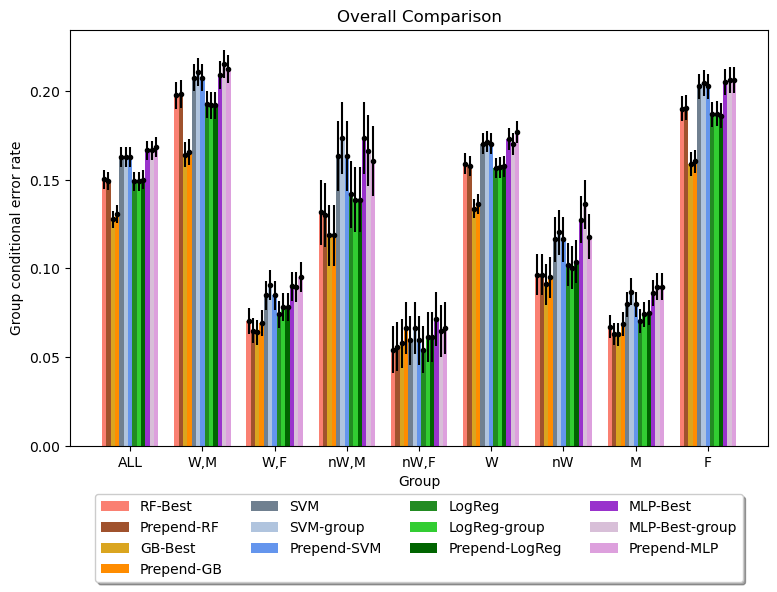

In [56]:
plot_group_labels = group_names
plot_x = np.arange(num_groups)
fig, ax = plt.subplots()
bar_width = 0.06

plot_rects1 = ax.bar(plot_x - 6.0*bar_width, [rf_best['erm_test_err'][g] for g in range(num_groups)], bar_width, label='RF-Best', color="salmon")
plot_rects2 = ax.bar(plot_x - 5.0*bar_width, [rf_prepend_best['F_test_err'][g] for g in range(num_groups)], bar_width, label='Prepend-RF', color="sienna")
plot_rects3 = ax.bar(plot_x - 4.0*bar_width, [gb_best['erm_test_err'][g] for g in range(num_groups)], bar_width, label='GB-Best', color="goldenrod")
plot_rects4 = ax.bar(plot_x - 3.0*bar_width, [gb_prepend_best['F_test_err'][g] for g in range(num_groups)], bar_width, label='Prepend-GB', color="darkorange")
plot_rects5 = ax.bar(plot_x - 2.0*bar_width, [svm['erm_test_err'][g] for g in range(num_groups)], bar_width, label='SVM', color="slategrey")
plot_rects6 = ax.bar(plot_x - 1.0*bar_width, [svm['test_err'][g] for g in range(num_groups)], bar_width, label='SVM-group', color="lightsteelblue")
plot_rects7 = ax.bar(plot_x, [svm_prepend['F_test_err'][g] for g in range(num_groups)], bar_width, label='Prepend-SVM', color="cornflowerblue")
plot_rects8 = ax.bar(plot_x + 1.0*bar_width, [logreg['erm_test_err'][g] for g in range(num_groups)], bar_width, label='LogReg', color="forestgreen")
plot_rects9 = ax.bar(plot_x + 2.0*bar_width, [logreg['test_err'][g] for g in range(num_groups)], bar_width, label='LogReg-group', color="limegreen")
plot_rects10 = ax.bar(plot_x + 3.0*bar_width, [logreg_prepend['F_test_err'][g] for g in range(num_groups)], bar_width, label='Prepend-LogReg', color="darkgreen")
plot_rects11 = ax.bar(plot_x + 4.0*bar_width, [mlp_best['erm_test_err'][g] for g in range(num_groups)], bar_width, label='MLP-Best', color="darkorchid")
plot_rects12 = ax.bar(plot_x + 5.0*bar_width, [mlp_best['test_err'][g] for g in range(num_groups)], bar_width, label='MLP-Best-group', color="thistle")
plot_rects13 = ax.bar(plot_x + 6.0*bar_width, [mlp_prepend_best['F_test_err'][g] for g in range(num_groups)], bar_width, label='Prepend-MLP', color="plum")

plot_err1 = ax.errorbar(plot_x - 6.0*bar_width, [rf_best['erm_test_err'][g] for g in range(num_groups)], [std_err(rf_best['erm_test_err'][g], num_group_test[g]) for g in range(num_groups)], fmt='.', color="Black")
plot_err2 = ax.errorbar(plot_x - 5.0*bar_width, [rf_prepend_best['F_test_err'][g] for g in range(num_groups)], [std_err(rf_prepend_best['F_test_err'][g], num_group_test[g]) for g in range(num_groups)], fmt='.', color="Black")
plot_err3 = ax.errorbar(plot_x - 4.0*bar_width, [gb_best['erm_test_err'][g] for g in range(num_groups)], [std_err(gb_best['erm_test_err'][g], num_group_test[g]) for g in range(num_groups)], fmt='.', color="Black")
plot_err4 = ax.errorbar(plot_x - 3.0*bar_width, [gb_prepend_best['F_test_err'][g] for g in range(num_groups)], [std_err(gb_prepend_best['F_test_err'][g], num_group_test[g]) for g in range(num_groups)], fmt='.', color="Black")
plot_err5 = ax.errorbar(plot_x - 2.0*bar_width, [svm['erm_test_err'][g] for g in range(num_groups)], [std_err(svm['erm_test_err'][g], num_group_test[g]) for g in range(num_groups)], fmt='.', color="Black")
plot_err6 = ax.errorbar(plot_x - 1.0*bar_width, [svm['test_err'][g] for g in range(num_groups)], [std_err(svm['test_err'][g], num_group_test[g]) for g in range(num_groups)], fmt='.', color="Black")
plot_err7 = ax.errorbar(plot_x, [svm_prepend['F_test_err'][g] for g in range(num_groups)], [std_err(svm_prepend['F_test_err'][g], num_group_test[g]) for g in range(num_groups)], fmt='.', color="Black")
plot_err8 = ax.errorbar(plot_x + 1.0*bar_width, [logreg['erm_test_err'][g] for g in range(num_groups)], [std_err(logreg['erm_test_err'][g], num_group_test[g]) for g in range(num_groups)], fmt='.', color="Black")
plot_err9 = ax.errorbar(plot_x + 2.0*bar_width, [logreg['test_err'][g] for g in range(num_groups)], [std_err(logreg['test_err'][g], num_group_test[g]) for g in range(num_groups)], fmt='.', color="Black")
plot_err10 = ax.errorbar(plot_x + 3.0*bar_width, [logreg_prepend['F_test_err'][g] for g in range(num_groups)], [std_err(logreg_prepend['F_test_err'][g], num_group_test[g]) for g in range(num_groups)], fmt='.', color="Black")
plot_err11 = ax.errorbar(plot_x + 4.0*bar_width, [mlp_best['erm_test_err'][g] for g in range(num_groups)], [std_err(mlp_best['erm_test_err'][g], num_group_test[g]) for g in range(num_groups)], fmt='.', color="Black")
plot_err12 = ax.errorbar(plot_x + 5.0*bar_width, [mlp_best['test_err'][g] for g in range(num_groups)], [std_err(mlp_best['test_err'][g], num_group_test[g]) for g in range(num_groups)], fmt='.', color="Black")
plot_err13 = ax.errorbar(plot_x + 6.0*bar_width, [mlp_prepend_best['F_test_err'][g] for g in range(num_groups)], [std_err(mlp_prepend_best['F_test_err'][g], num_group_test[g]) for g in range(num_groups)], fmt='.', color="Black")

ax.set_ylabel('Group conditional error rate')
ax.set_xlabel('Group')
ax.set_xticks(plot_x, plot_group_labels)
fig.set_size_inches(9., 6.)
ax.set_title("Overall Comparison")

# Put a legend below current axis
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])

ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),
          fancybox=True, shadow=True, ncol=4)

plt.show()

### Plot 2: Worst-Group Comparison
Plot the average error and worst-group error of each model instantiation from the hyperparameter sweep.

Also, print out the average and worst-group error of each of these points for easier direct comparison.

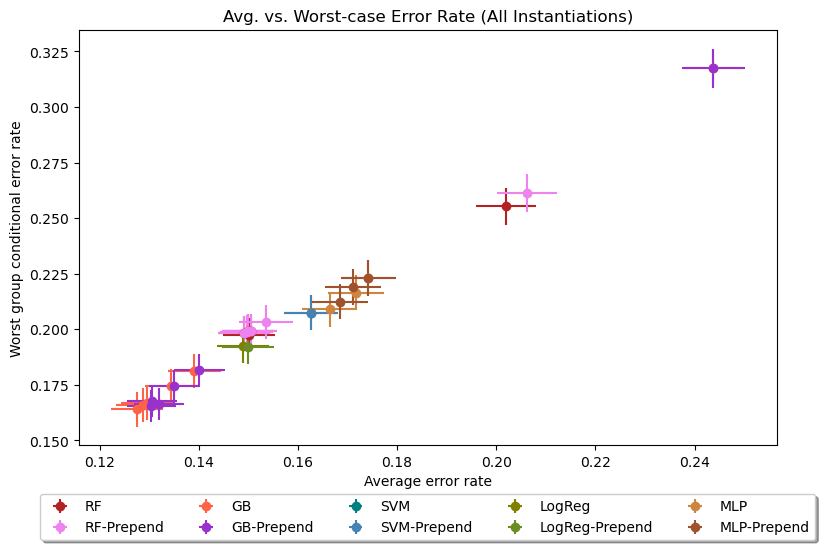

In [57]:
fig, ax = plt.subplots()

# Plot all points for tree-based models
# Random Forests
x_rfs = [all_rfs[num_trees]['erm_test_err'][0] for num_trees in tree_params]
y_rfs = [all_rfs[num_trees]['worst_gp_err'][0] for num_trees in tree_params]
x_rfs_errs = [std_err(err, num_group_test[0]) for err in x_rfs]
y_rfs_errs = [std_err(err, num_group_test[1]) for err in y_rfs]
ax.errorbar(x_rfs, y_rfs, xerr=x_rfs_errs, yerr=y_rfs_errs, fmt='o', label='RF', color="firebrick")

# Prepend: Random Forests
x_rf_prepend = [rf_prepend[num_trees]['F_test_err'][0] for num_trees in tree_params]
y_rf_prepend = [rf_prepend[num_trees]['worst_gp_err'][0] for num_trees in tree_params]
x_rf_prepend_errs = [std_err(err, num_group_test[0]) for err in x_rf_prepend]
y_rf_prepend_errs = [std_err(err, num_group_test[1]) for err in y_rf_prepend]
ax.errorbar(x_rf_prepend, y_rf_prepend, xerr=x_rf_prepend_errs, yerr=y_rf_prepend_errs, fmt='o', label='RF-Prepend', color="violet")

# Gradient-Boosted Trees
x_gbs = [all_gbs[num_trees]['erm_test_err'][0] for num_trees in tree_params]
y_gbs = [all_gbs[num_trees]['worst_gp_err'][0] for num_trees in tree_params]
x_gbs_errs = [std_err(err, num_group_test[0]) for err in x_rfs]
y_gbs_errs = [std_err(err, num_group_test[1]) for err in y_rfs]
ax.errorbar(x_gbs, y_gbs, xerr=x_gbs_errs, yerr=y_gbs_errs, fmt='o', label='GB', color="tomato")

# Prepend: Gradient-Boosted Trees
x_gb_prepend = [gb_prepend[num_trees]['F_test_err'][0] for num_trees in tree_params]
y_gb_prepend = [gb_prepend[num_trees]['worst_gp_err'][0] for num_trees in tree_params]
x_gb_prepend_errs = [std_err(err, num_group_test[0]) for err in x_gb_prepend]
y_gb_prepend_errs = [std_err(err, num_group_test[1]) for err in y_gb_prepend]
ax.errorbar(x_gb_prepend, y_gb_prepend, xerr=x_gb_prepend_errs, yerr=y_gb_prepend_errs, fmt='o', label='GB-Prepend', color="darkorchid")

# SVM
x_svm = [svm['erm_test_err'][0]]
y_svm = [svm['worst_gp_err'][0]]
x_svm_errs = [std_err(err, num_group_test[0]) for err in x_svm]
y_svm_errs = [std_err(err, num_group_test[1]) for err in y_svm]
ax.errorbar(x_svm, y_svm, xerr=x_svm_errs, yerr=y_svm_errs, fmt='o', label="SVM", color="teal")

# Prepend: SVM
x_svm_prepend = [svm_prepend['F_test_err'][0]]
y_svm_prepend = [svm_prepend['worst_gp_err'][0]]
x_svm_prepend_errs = [std_err(err, num_group_test[0]) for err in x_svm_prepend]
y_svm_prepend_errs = [std_err(err, num_group_test[1]) for err in y_svm_prepend]
ax.errorbar(x_svm_prepend, y_svm_prepend, xerr=x_svm_prepend_errs, yerr=y_svm_prepend_errs, fmt='o', label="SVM-Prepend", color="steelblue")

# Logistic Regression
x_logreg = [logreg['erm_test_err'][0]]
y_logreg = [logreg['worst_gp_err'][0]]
x_logreg_errs = [std_err(err, num_group_test[0]) for err in x_logreg]
y_logreg_errs = [std_err(err, num_group_test[1]) for err in y_logreg]
ax.errorbar(x_logreg, y_logreg, xerr=x_logreg_errs, yerr=y_logreg_errs, fmt='o', label="LogReg", color="olive")

# Prepend: Logistic Regression
x_logreg_prepend = [logreg_prepend['F_test_err'][0]]
y_logreg_prepend = [logreg_prepend['worst_gp_err'][0]]
x_logreg_prepend_errs = [std_err(err, num_group_test[0]) for err in x_logreg_prepend]
y_logreg_prepend_errs = [std_err(err, num_group_test[1]) for err in y_logreg_prepend]
ax.errorbar(x_logreg_prepend, y_logreg_prepend, xerr=x_logreg_prepend_errs, yerr=y_logreg_prepend_errs, fmt='o', label="LogReg-Prepend", color="olivedrab")

# MLPs
x_mlps = [all_mlps[hidden_units]['erm_test_err'][0] for hidden_units in hidden_unit_params]
y_mlps = [all_mlps[hidden_units]['worst_gp_err'][0] for hidden_units in hidden_unit_params]
x_mlps_errs = [std_err(err, num_group_test[0]) for err in x_mlps]
y_mlps_errs = [std_err(err, num_group_test[1]) for err in y_mlps]
ax.errorbar(x_mlps, y_mlps, xerr=x_mlps_errs, yerr=y_mlps_errs, fmt='o', label='MLP', color="peru")

# Prepend: MLPs
x_mlps_prepend = [mlps_prepend[hidden_units]['F_test_err'][0] for hidden_units in hidden_unit_params]
y_mlps_prepend = [mlps_prepend[hidden_units]['worst_gp_err'][0] for hidden_units in hidden_unit_params]
x_mlps_prepend_errs = [std_err(err, num_group_test[0]) for err in x_mlps_prepend]
y_mlps_prepend_errs = [std_err(err, num_group_test[1]) for err in y_mlps_prepend]
ax.errorbar(x_mlps_prepend, y_mlps_prepend, xerr=x_mlps_prepend_errs, yerr=y_mlps_prepend_errs, fmt='o', label='MLP-Prepend', color="sienna")

ax.set_xlabel('Average error rate')
ax.set_ylabel('Worst group conditional error rate')
fig.set_size_inches(9., 6.)
ax.set_title("Avg. vs. Worst-case Error Rate (All Instantiations)")

# Put legend underneath plot
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])

ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),
          fancybox=True, shadow=True, ncol=5)

In [58]:
# Best observed average case error, per model class
print("Best Observed Average-Case Errors:")
print('RF:\t\t{0} (+/-{1})'.format(min(x_rfs), std_err(min(x_rfs), num_group_test[0])))
print('RF-Prepend:\t{0} (+/-{1})'.format(min(x_rf_prepend), std_err(min(x_rf_prepend), num_group_test[0])))
print('GB:\t\t{0} (+/-{1})'.format(min(x_gbs), std_err(min(x_gbs), num_group_test[0])))
print('GB-Prepend:\t{0} (+/-{1})'.format(min(x_gb_prepend), std_err(min(x_gb_prepend), num_group_test[0])))
print('SVM:\t\t{0} (+/-{1})'.format(min(x_svm), std_err(min(x_svm), num_group_test[0])))
print('SVM-Prepend:\t{0} (+/-{1})'.format(min(x_svm_prepend), std_err(min(x_svm_prepend), num_group_test[0])))
print('LogReg:\t\t{0} (+/-{1})'.format(min(x_logreg), std_err(min(x_logreg), num_group_test[0])))
print('LogReg-Prepend:\t{0} (+/-{1})'.format(min(x_logreg_prepend), std_err(min(x_logreg_prepend), num_group_test[0])))
print('MLP:\t\t{0} (+/-{1})'.format(min(x_mlps), std_err(min(x_mlps), num_group_test[0])))
print('MLP-Prepend:\t{0} (+/-{1})'.format(min(x_mlps_prepend), std_err(min(x_mlps_prepend), num_group_test[0])))

Best Observed Average-Case Errors:
RF:		0.14914317302377003 (+/-0.005297130171307789)
RF-Prepend:	0.14914317302377003 (+/-0.005297130171307789)
GB:		0.12758430071862908 (+/-0.004961021019770001)
GB-Prepend:	0.1304588170259812 (+/-0.005008325055771677)
SVM:		0.16263128800442234 (+/-0.005487456970751335)
SVM-Prepend:	0.16263128800442234 (+/-0.005487456970751335)
LogReg:		0.14892205638474296 (+/-0.005293889747457745)
LogReg-Prepend:	0.14991708126036485 (+/-0.005308440039837308)
MLP:		0.1663902708678828 (+/-0.005538039690222516)
MLP-Prepend:	0.16849087893864012 (+/-0.005565861803227889)


In [59]:
# Best observed worst-group error, per model class
print("Best Observed Worst-Case Errors:")
print('RF:\t\t{0} (+/-{1})'.format(min(y_rfs), std_err(min(y_rfs), num_group_test[1])))
print('RF-Prepend:\t{0} (+/-{1})'.format(min(y_rf_prepend), std_err(min(y_rf_prepend), num_group_test[1])))
print('GB:\t\t{0} (+/-{1})'.format(min(y_gbs), std_err(min(y_gbs), num_group_test[1])))
print('GB-Prepend:\t{0} (+/-{1})'.format(min(y_gb_prepend), std_err(min(y_gb_prepend), num_group_test[1])))
print('SVM:\t\t{0} (+/-{1})'.format(min(y_svm), std_err(min(y_svm), num_group_test[1])))
print('SVM-Prepend:\t{0} (+/-{1})'.format(min(y_svm_prepend), std_err(min(y_svm_prepend), num_group_test[1])))
print('LogReg:\t\t{0} (+/-{1})'.format(min(y_logreg), std_err(min(y_logreg), num_group_test[1])))
print('LogReg-Prepend:\t{0} (+/-{1})'.format(min(y_logreg_prepend), std_err(min(y_logreg_prepend), num_group_test[1])))
print('MLP:\t\t{0} (+/-{1})'.format(min(y_mlps), std_err(min(y_mlps), num_group_test[1])))
print('MLP-Prepend:\t{0} (+/-{1})'.format(min(y_mlps_prepend), std_err(min(y_mlps_prepend), num_group_test[1])))

Best Observed Worst-Case Errors:
RF:		0.1975263060734724 (+/-0.0076500355508504)
RF-Prepend:	0.19826472217094332 (+/-0.0076607942745930595)
GB:		0.16392837363854532 (+/-0.007113517228493676)
GB-Prepend:	0.1655898098578549 (+/-0.007142367351400359)
SVM:		0.2074949233893299 (+/-0.0077918457103755565)
SVM-Prepend:	0.2074949233893299 (+/-0.0077918457103755565)
LogReg:		0.19254199741554365 (+/-0.0075763196231075644)
LogReg-Prepend:	0.19198818534244047 (+/-0.0075680098284835315)
MLP:		0.20897175558427172 (+/-0.007812236298280615)
MLP-Prepend:	0.2122946280228909 (+/-0.007857546975090945)


### Plot 3: Tree Ensemble Comparison
For each group, we compare the effect of ensemble size (`n_estimators`) on the group performance of each tree-based method.
Include two plots: one for Random Forests and one for Gradient-Boosted Trees.

In [60]:
print(num_estimator_params)

[1, 64, 128, 256, 512, 1024]


In [61]:
from sklearn.tree import DecisionTreeClassifier
dec_tree_params = {
    "random_state" : 0,
    "max_features" : "sqrt"
}

# Does n_estimators=1 RF do the same thing as DecisionTree (CART)?
dec_tree = train_and_eval(X_train, group_train, X_test, group_test, y_train, y_test,
                        col_transf, num_groups, DecisionTreeClassifier, "Decision Tree",
                        "N/A", "N/A", dec_tree_params, verbose=True)

print("Random Forests (n_estimators=1)")
print(all_rfs[1]['test_err'])

Decision Tree (N/A=N/A)
group 0 (ALL): 0.20143725815367605 (+/-0.005963965668636379; n=9045)
group 1 (W,M): 0.24386191618977293 (+/-0.008251029260357748; n=5417)
group 2 (W,F): 0.10156580617858654 (+/-0.008788202051466607; n=2363)
group 3 (nW,M): 0.18786127167630057 (+/-0.02099885864504078; n=692)
group 4 (nW,F): 0.09424083769633508 (+/-0.017260907440733962; n=573)
group 5 (W): 0.20218508997429305 (+/-0.0064394805584629755; n=7780)
group 6 (nW): 0.1383399209486166 (+/-0.013728133153287187; n=1265)
group 7 (M): 0.10694822888283378 (+/-0.008066071895202066; n=2936)
group 8 (F): 0.23555410050744802 (+/-0.007678009539798146; n=6109)
PREPEND group 0 (ALL): 0.20143725815367605 (+/-0.005963965668636379; n=9045)
PREPEND group 1 (W,M): 0.25512276167620457 (+/-0.00837630602042881; n=5417)
PREPEND group 2 (W,F): 0.10325856961489632 (+/-0.00885278275565467; n=2363)
PREPEND group 3 (nW,M): 0.2023121387283237 (+/-0.02159680031772899; n=692)
PREPEND group 4 (nW,F): 0.09773123909249563 (+/-0.017543746

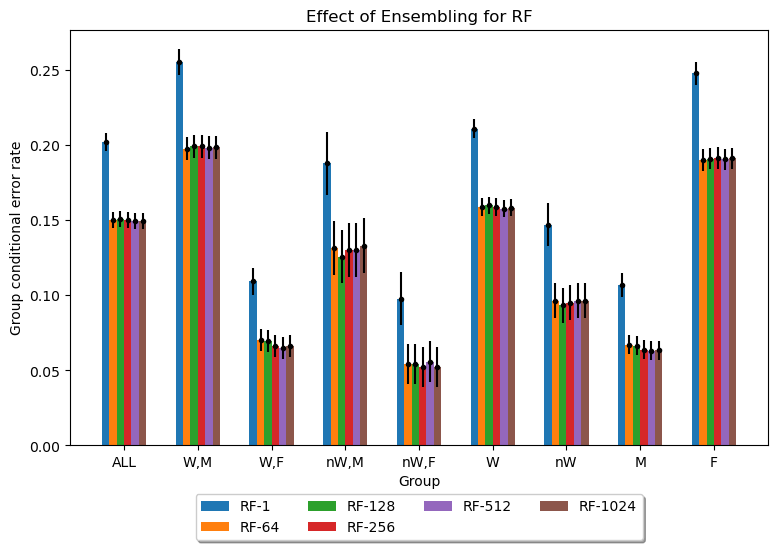

In [62]:
# Ensemble Comparison: Random Forests
plot_group_labels = group_names
plot_x = np.arange(num_groups)
fig, ax = plt.subplots()
bar_width = 0.1

plot_rects1 = ax.bar(plot_x - 2.5*bar_width, [all_rfs[1]['erm_test_err'][g] for g in range(num_groups)], bar_width, label='RF-1')
plot_rects2 = ax.bar(plot_x - 1.5*bar_width, [all_rfs[64]['erm_test_err'][g] for g in range(num_groups)], bar_width, label='RF-64')
plot_rects3 = ax.bar(plot_x - 0.5*bar_width, [all_rfs[128]['erm_test_err'][g] for g in range(num_groups)], bar_width, label='RF-128')
plot_rects4 = ax.bar(plot_x + 0.5*bar_width, [all_rfs[256]['erm_test_err'][g] for g in range(num_groups)], bar_width, label='RF-256')
plot_rects5 = ax.bar(plot_x + 1.5*bar_width, [all_rfs[512]['erm_test_err'][g] for g in range(num_groups)], bar_width, label='RF-512')
plot_rects6 = ax.bar(plot_x + 2.5*bar_width, [all_rfs[1024]['erm_test_err'][g] for g in range(num_groups)], bar_width, label='RF-1024')

plot_err1 = ax.errorbar(plot_x - 2.5*bar_width, [all_rfs[1]['erm_test_err'][g] for g in range(num_groups)], [std_err(all_rfs[1]['erm_test_err'][g], num_group_test[g]) for g in range(num_groups)], fmt='.', color="Black")
plot_err2 = ax.errorbar(plot_x - 1.5*bar_width, [all_rfs[64]['erm_test_err'][g] for g in range(num_groups)], [std_err(all_rfs[64]['erm_test_err'][g], num_group_test[g]) for g in range(num_groups)], fmt='.', color="Black")
plot_err3 = ax.errorbar(plot_x - 0.5*bar_width, [all_rfs[128]['erm_test_err'][g] for g in range(num_groups)], [std_err(all_rfs[128]['erm_test_err'][g], num_group_test[g]) for g in range(num_groups)], fmt='.', color="Black")
plot_err4 = ax.errorbar(plot_x + 0.5*bar_width, [all_rfs[256]['erm_test_err'][g] for g in range(num_groups)], [std_err(all_rfs[256]['erm_test_err'][g], num_group_test[g]) for g in range(num_groups)], fmt='.', color="Black")
plot_err5 = ax.errorbar(plot_x + 1.5*bar_width, [all_rfs[512]['erm_test_err'][g] for g in range(num_groups)], [std_err(all_rfs[512]['erm_test_err'][g], num_group_test[g]) for g in range(num_groups)], fmt='.', color="Black")
plot_err6 = ax.errorbar(plot_x + 2.5*bar_width, [all_rfs[1024]['erm_test_err'][g] for g in range(num_groups)], [std_err(all_rfs[1024]['erm_test_err'][g], num_group_test[g]) for g in range(num_groups)], fmt='.', color="Black")

ax.set_ylabel('Group conditional error rate')
ax.set_xlabel('Group')
ax.set_xticks(plot_x, plot_group_labels)
fig.set_size_inches(9., 6.)
ax.set_title("Effect of Ensembling for RF")

# Put a legend below current axis
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])

ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),
          fancybox=True, shadow=True, ncol=4)

plt.show()

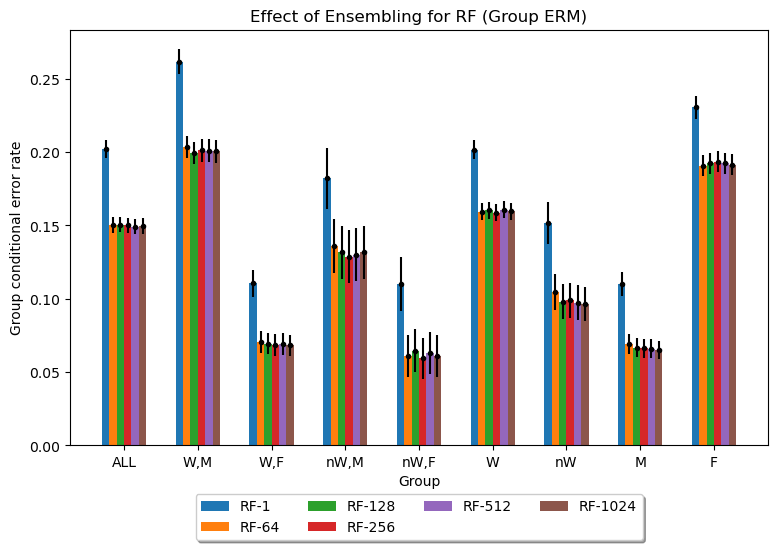

In [63]:
# Ensemble Comparison: Random Forests
plot_group_labels = group_names
plot_x = np.arange(num_groups)
fig, ax = plt.subplots()
bar_width = 0.1

plot_rects1 = ax.bar(plot_x - 2.5*bar_width, [all_rfs[1]['test_err'][g] for g in range(num_groups)], bar_width, label='RF-1')
plot_rects2 = ax.bar(plot_x - 1.5*bar_width, [all_rfs[64]['test_err'][g] for g in range(num_groups)], bar_width, label='RF-64')
plot_rects3 = ax.bar(plot_x - 0.5*bar_width, [all_rfs[128]['test_err'][g] for g in range(num_groups)], bar_width, label='RF-128')
plot_rects4 = ax.bar(plot_x + 0.5*bar_width, [all_rfs[256]['test_err'][g] for g in range(num_groups)], bar_width, label='RF-256')
plot_rects5 = ax.bar(plot_x + 1.5*bar_width, [all_rfs[512]['test_err'][g] for g in range(num_groups)], bar_width, label='RF-512')
plot_rects6 = ax.bar(plot_x + 2.5*bar_width, [all_rfs[1024]['test_err'][g] for g in range(num_groups)], bar_width, label='RF-1024')

plot_err1 = ax.errorbar(plot_x - 2.5*bar_width, [all_rfs[1]['test_err'][g] for g in range(num_groups)], [std_err(all_rfs[1]['test_err'][g], num_group_test[g]) for g in range(num_groups)], fmt='.', color="Black")
plot_err2 = ax.errorbar(plot_x - 1.5*bar_width, [all_rfs[64]['test_err'][g] for g in range(num_groups)], [std_err(all_rfs[64]['test_err'][g], num_group_test[g]) for g in range(num_groups)], fmt='.', color="Black")
plot_err3 = ax.errorbar(plot_x - 0.5*bar_width, [all_rfs[128]['test_err'][g] for g in range(num_groups)], [std_err(all_rfs[128]['test_err'][g], num_group_test[g]) for g in range(num_groups)], fmt='.', color="Black")
plot_err4 = ax.errorbar(plot_x + 0.5*bar_width, [all_rfs[256]['test_err'][g] for g in range(num_groups)], [std_err(all_rfs[256]['test_err'][g], num_group_test[g]) for g in range(num_groups)], fmt='.', color="Black")
plot_err5 = ax.errorbar(plot_x + 1.5*bar_width, [all_rfs[512]['test_err'][g] for g in range(num_groups)], [std_err(all_rfs[512]['test_err'][g], num_group_test[g]) for g in range(num_groups)], fmt='.', color="Black")
plot_err6 = ax.errorbar(plot_x + 2.5*bar_width, [all_rfs[1024]['test_err'][g] for g in range(num_groups)], [std_err(all_rfs[1024]['test_err'][g], num_group_test[g]) for g in range(num_groups)], fmt='.', color="Black")

ax.set_ylabel('Group conditional error rate')
ax.set_xlabel('Group')
ax.set_xticks(plot_x, plot_group_labels)
fig.set_size_inches(9., 6.)
ax.set_title("Effect of Ensembling for RF (Group ERM)")

# Put a legend below current axis
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])

ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),
          fancybox=True, shadow=True, ncol=4)

plt.show()

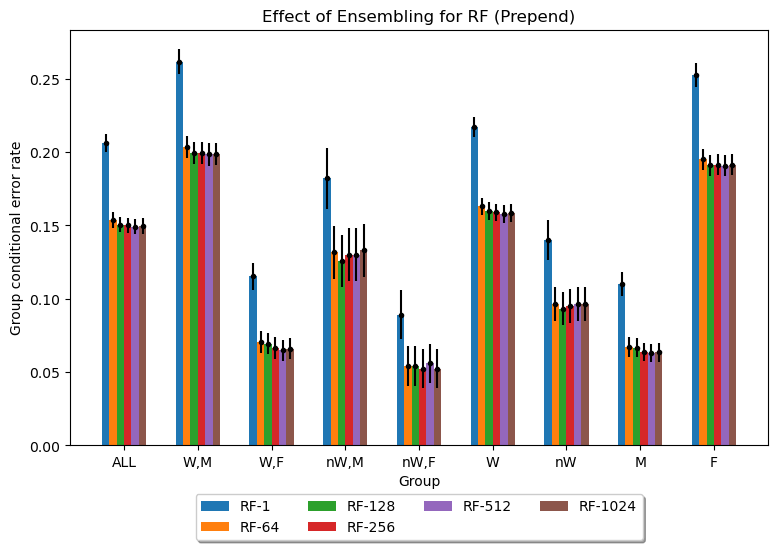

In [64]:
# Ensemble Comparison: Random Forests
plot_group_labels = group_names
plot_x = np.arange(num_groups)
fig, ax = plt.subplots()
bar_width = 0.1

plot_rects1 = ax.bar(plot_x - 2.5*bar_width, [rf_prepend[1]['F_test_err'][g] for g in range(num_groups)], bar_width, label='RF-1')
plot_rects2 = ax.bar(plot_x - 1.5*bar_width, [rf_prepend[64]['F_test_err'][g] for g in range(num_groups)], bar_width, label='RF-64')
plot_rects3 = ax.bar(plot_x - 0.5*bar_width, [rf_prepend[128]['F_test_err'][g] for g in range(num_groups)], bar_width, label='RF-128')
plot_rects4 = ax.bar(plot_x + 0.5*bar_width, [rf_prepend[256]['F_test_err'][g] for g in range(num_groups)], bar_width, label='RF-256')
plot_rects5 = ax.bar(plot_x + 1.5*bar_width, [rf_prepend[512]['F_test_err'][g] for g in range(num_groups)], bar_width, label='RF-512')
plot_rects6 = ax.bar(plot_x + 2.5*bar_width, [rf_prepend[1024]['F_test_err'][g] for g in range(num_groups)], bar_width, label='RF-1024')

plot_err1 = ax.errorbar(plot_x - 2.5*bar_width, [rf_prepend[1]['F_test_err'][g] for g in range(num_groups)], [std_err(rf_prepend[1]['F_test_err'][g], num_group_test[g]) for g in range(num_groups)], fmt='.', color="Black")
plot_err2 = ax.errorbar(plot_x - 1.5*bar_width, [rf_prepend[64]['F_test_err'][g] for g in range(num_groups)], [std_err(rf_prepend[64]['F_test_err'][g], num_group_test[g]) for g in range(num_groups)], fmt='.', color="Black")
plot_err3 = ax.errorbar(plot_x - 0.5*bar_width, [rf_prepend[128]['F_test_err'][g] for g in range(num_groups)], [std_err(rf_prepend[128]['F_test_err'][g], num_group_test[g]) for g in range(num_groups)], fmt='.', color="Black")
plot_err4 = ax.errorbar(plot_x + 0.5*bar_width, [rf_prepend[256]['F_test_err'][g] for g in range(num_groups)], [std_err(rf_prepend[256]['F_test_err'][g], num_group_test[g]) for g in range(num_groups)], fmt='.', color="Black")
plot_err5 = ax.errorbar(plot_x + 1.5*bar_width, [rf_prepend[512]['F_test_err'][g] for g in range(num_groups)], [std_err(rf_prepend[512]['F_test_err'][g], num_group_test[g]) for g in range(num_groups)], fmt='.', color="Black")
plot_err6 = ax.errorbar(plot_x + 2.5*bar_width, [rf_prepend[1024]['F_test_err'][g] for g in range(num_groups)], [std_err(rf_prepend[1024]['F_test_err'][g], num_group_test[g]) for g in range(num_groups)], fmt='.', color="Black")

ax.set_ylabel('Group conditional error rate')
ax.set_xlabel('Group')
ax.set_xticks(plot_x, plot_group_labels)
fig.set_size_inches(9., 6.)
ax.set_title("Effect of Ensembling for RF (Prepend)")

# Put a legend below current axis
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])

ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),
          fancybox=True, shadow=True, ncol=4)

plt.show()

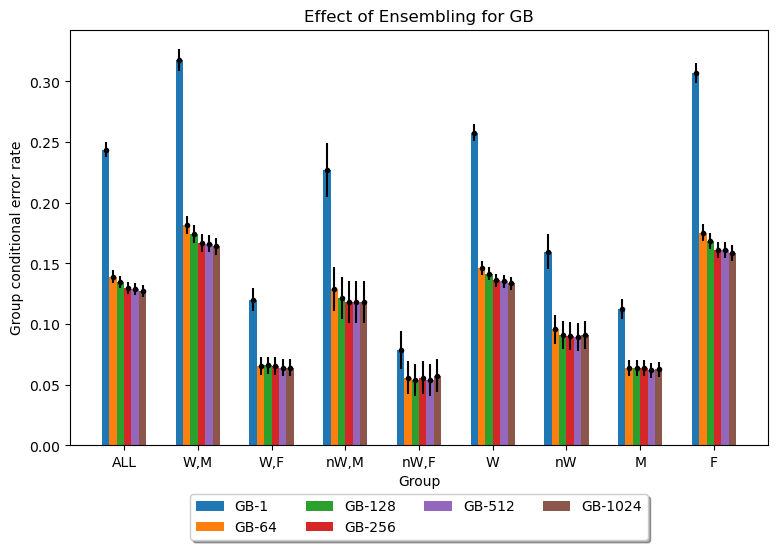

In [65]:
# Ensemble Comparison: Gradient-Boosted Trees
plot_group_labels = group_names
plot_x = np.arange(num_groups)
fig, ax = plt.subplots()
bar_width = 0.1

plot_rects1 = ax.bar(plot_x - 2.5*bar_width, [all_gbs[1]['erm_test_err'][g] for g in range(num_groups)], bar_width, label='GB-1')
plot_rects2 = ax.bar(plot_x - 1.5*bar_width, [all_gbs[64]['erm_test_err'][g] for g in range(num_groups)], bar_width, label='GB-64')
plot_rects3 = ax.bar(plot_x - 0.5*bar_width, [all_gbs[128]['erm_test_err'][g] for g in range(num_groups)], bar_width, label='GB-128')
plot_rects4 = ax.bar(plot_x + 0.5*bar_width, [all_gbs[256]['erm_test_err'][g] for g in range(num_groups)], bar_width, label='GB-256')
plot_rects5 = ax.bar(plot_x + 1.5*bar_width, [all_gbs[512]['erm_test_err'][g] for g in range(num_groups)], bar_width, label='GB-512')
plot_rects6 = ax.bar(plot_x + 2.5*bar_width, [all_gbs[1024]['erm_test_err'][g] for g in range(num_groups)], bar_width, label='GB-1024')

plot_err1 = ax.errorbar(plot_x - 2.5*bar_width, [all_gbs[1]['erm_test_err'][g] for g in range(num_groups)], [std_err(all_gbs[1]['erm_test_err'][g], num_group_test[g]) for g in range(num_groups)], fmt='.', color="Black")
plot_err2 = ax.errorbar(plot_x - 1.5*bar_width, [all_gbs[64]['erm_test_err'][g] for g in range(num_groups)], [std_err(all_gbs[64]['erm_test_err'][g], num_group_test[g]) for g in range(num_groups)], fmt='.', color="Black")
plot_err3 = ax.errorbar(plot_x - 0.5*bar_width, [all_gbs[128]['erm_test_err'][g] for g in range(num_groups)], [std_err(all_gbs[128]['erm_test_err'][g], num_group_test[g]) for g in range(num_groups)], fmt='.', color="Black")
plot_err4 = ax.errorbar(plot_x + 0.5*bar_width, [all_gbs[256]['erm_test_err'][g] for g in range(num_groups)], [std_err(all_gbs[256]['erm_test_err'][g], num_group_test[g]) for g in range(num_groups)], fmt='.', color="Black")
plot_err5 = ax.errorbar(plot_x + 1.5*bar_width, [all_gbs[512]['erm_test_err'][g] for g in range(num_groups)], [std_err(all_gbs[512]['erm_test_err'][g], num_group_test[g]) for g in range(num_groups)], fmt='.', color="Black")
plot_err6 = ax.errorbar(plot_x + 2.5*bar_width, [all_gbs[1024]['erm_test_err'][g] for g in range(num_groups)], [std_err(all_gbs[1024]['erm_test_err'][g], num_group_test[g]) for g in range(num_groups)], fmt='.', color="Black")

ax.set_ylabel('Group conditional error rate')
ax.set_xlabel('Group')
ax.set_xticks(plot_x, plot_group_labels)
fig.set_size_inches(9., 6.)
ax.set_title("Effect of Ensembling for GB")

# Put a legend below current axis
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])

ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),
          fancybox=True, shadow=True, ncol=4)

plt.show()

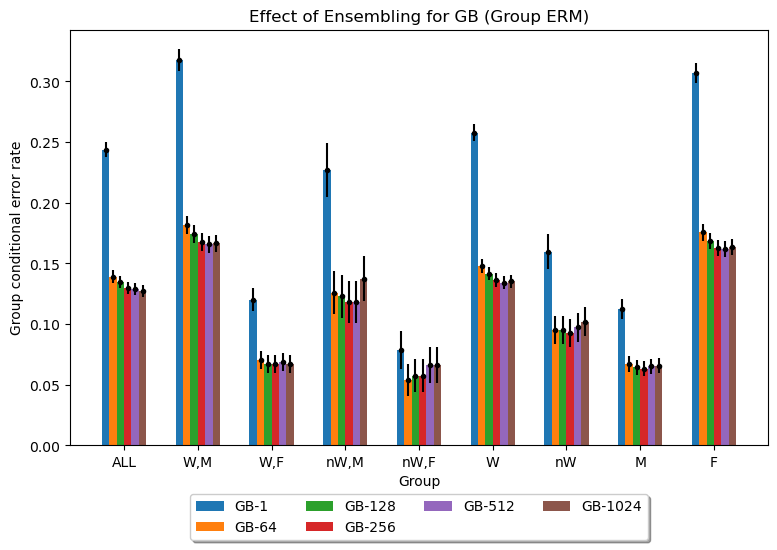

In [66]:
# Ensemble Comparison: Gradient-Boosted Trees
plot_group_labels = group_names
plot_x = np.arange(num_groups)
fig, ax = plt.subplots()
bar_width = 0.1

plot_rects1 = ax.bar(plot_x - 2.5*bar_width, [all_gbs[1]['test_err'][g] for g in range(num_groups)], bar_width, label='GB-1')
plot_rects2 = ax.bar(plot_x - 1.5*bar_width, [all_gbs[64]['test_err'][g] for g in range(num_groups)], bar_width, label='GB-64')
plot_rects3 = ax.bar(plot_x - 0.5*bar_width, [all_gbs[128]['test_err'][g] for g in range(num_groups)], bar_width, label='GB-128')
plot_rects4 = ax.bar(plot_x + 0.5*bar_width, [all_gbs[256]['test_err'][g] for g in range(num_groups)], bar_width, label='GB-256')
plot_rects5 = ax.bar(plot_x + 1.5*bar_width, [all_gbs[512]['test_err'][g] for g in range(num_groups)], bar_width, label='GB-512')
plot_rects6 = ax.bar(plot_x + 2.5*bar_width, [all_gbs[1024]['test_err'][g] for g in range(num_groups)], bar_width, label='GB-1024')

plot_err1 = ax.errorbar(plot_x - 2.5*bar_width, [all_gbs[1]['test_err'][g] for g in range(num_groups)], [std_err(all_gbs[1]['test_err'][g], num_group_test[g]) for g in range(num_groups)], fmt='.', color="Black")
plot_err2 = ax.errorbar(plot_x - 1.5*bar_width, [all_gbs[64]['test_err'][g] for g in range(num_groups)], [std_err(all_gbs[64]['test_err'][g], num_group_test[g]) for g in range(num_groups)], fmt='.', color="Black")
plot_err3 = ax.errorbar(plot_x - 0.5*bar_width, [all_gbs[128]['test_err'][g] for g in range(num_groups)], [std_err(all_gbs[128]['test_err'][g], num_group_test[g]) for g in range(num_groups)], fmt='.', color="Black")
plot_err4 = ax.errorbar(plot_x + 0.5*bar_width, [all_gbs[256]['test_err'][g] for g in range(num_groups)], [std_err(all_gbs[256]['test_err'][g], num_group_test[g]) for g in range(num_groups)], fmt='.', color="Black")
plot_err5 = ax.errorbar(plot_x + 1.5*bar_width, [all_gbs[512]['test_err'][g] for g in range(num_groups)], [std_err(all_gbs[512]['test_err'][g], num_group_test[g]) for g in range(num_groups)], fmt='.', color="Black")
plot_err6 = ax.errorbar(plot_x + 2.5*bar_width, [all_gbs[1024]['test_err'][g] for g in range(num_groups)], [std_err(all_gbs[1024]['test_err'][g], num_group_test[g]) for g in range(num_groups)], fmt='.', color="Black")

ax.set_ylabel('Group conditional error rate')
ax.set_xlabel('Group')
ax.set_xticks(plot_x, plot_group_labels)
fig.set_size_inches(9., 6.)
ax.set_title("Effect of Ensembling for GB (Group ERM)")

# Put a legend below current axis
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])

ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),
          fancybox=True, shadow=True, ncol=4)

plt.show()

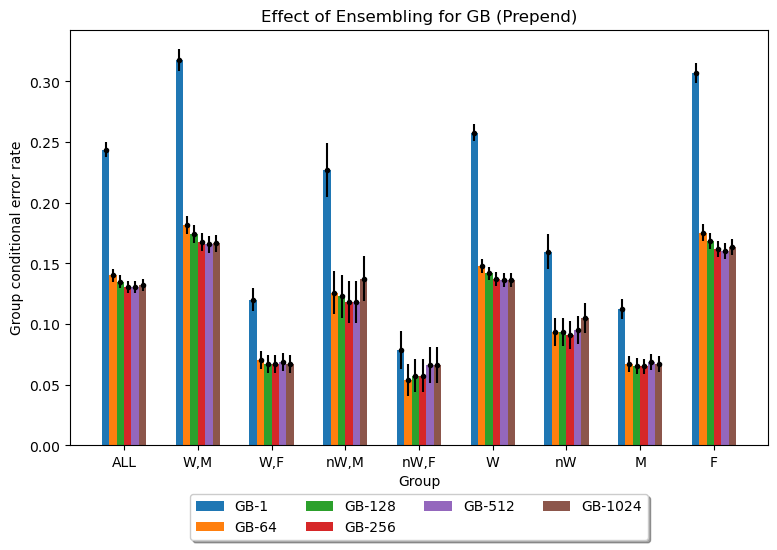

In [67]:
# Ensemble Comparison: Gradient-Boosted Trees
plot_group_labels = group_names
plot_x = np.arange(num_groups)
fig, ax = plt.subplots()
bar_width = 0.1

plot_rects1 = ax.bar(plot_x - 2.5*bar_width, [gb_prepend[1]['F_test_err'][g] for g in range(num_groups)], bar_width, label='GB-1')
plot_rects2 = ax.bar(plot_x - 1.5*bar_width, [gb_prepend[64]['F_test_err'][g] for g in range(num_groups)], bar_width, label='GB-64')
plot_rects3 = ax.bar(plot_x - 0.5*bar_width, [gb_prepend[128]['F_test_err'][g] for g in range(num_groups)], bar_width, label='GB-128')
plot_rects4 = ax.bar(plot_x + 0.5*bar_width, [gb_prepend[256]['F_test_err'][g] for g in range(num_groups)], bar_width, label='GB-256')
plot_rects5 = ax.bar(plot_x + 1.5*bar_width, [gb_prepend[512]['F_test_err'][g] for g in range(num_groups)], bar_width, label='GB-512')
plot_rects6 = ax.bar(plot_x + 2.5*bar_width, [gb_prepend[1024]['F_test_err'][g] for g in range(num_groups)], bar_width, label='GB-1024')

plot_err1 = ax.errorbar(plot_x - 2.5*bar_width, [gb_prepend[1]['F_test_err'][g] for g in range(num_groups)], [std_err(gb_prepend[1]['F_test_err'][g], num_group_test[g]) for g in range(num_groups)], fmt='.', color="Black")
plot_err2 = ax.errorbar(plot_x - 1.5*bar_width, [gb_prepend[64]['F_test_err'][g] for g in range(num_groups)], [std_err(gb_prepend[64]['F_test_err'][g], num_group_test[g]) for g in range(num_groups)], fmt='.', color="Black")
plot_err3 = ax.errorbar(plot_x - 0.5*bar_width, [gb_prepend[128]['F_test_err'][g] for g in range(num_groups)], [std_err(gb_prepend[128]['F_test_err'][g], num_group_test[g]) for g in range(num_groups)], fmt='.', color="Black")
plot_err4 = ax.errorbar(plot_x + 0.5*bar_width, [gb_prepend[256]['F_test_err'][g] for g in range(num_groups)], [std_err(gb_prepend[256]['F_test_err'][g], num_group_test[g]) for g in range(num_groups)], fmt='.', color="Black")
plot_err5 = ax.errorbar(plot_x + 1.5*bar_width, [gb_prepend[512]['F_test_err'][g] for g in range(num_groups)], [std_err(gb_prepend[512]['F_test_err'][g], num_group_test[g]) for g in range(num_groups)], fmt='.', color="Black")
plot_err6 = ax.errorbar(plot_x + 2.5*bar_width, [gb_prepend[1024]['F_test_err'][g] for g in range(num_groups)], [std_err(gb_prepend[1024]['F_test_err'][g], num_group_test[g]) for g in range(num_groups)], fmt='.', color="Black")

ax.set_ylabel('Group conditional error rate')
ax.set_xlabel('Group')
ax.set_xticks(plot_x, plot_group_labels)
fig.set_size_inches(9., 6.)
ax.set_title("Effect of Ensembling for GB (Prepend)")

# Put a legend below current axis
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])

ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),
          fancybox=True, shadow=True, ncol=4)

plt.show()